### **Análise de Tweets**



In [1]:
import tweepy 
import pandas as pd     
import numpy as np 
import matplotlib.pyplot as plt
from textblob import TextBlob as tb

**Autenticação no Twitter**

In [2]:
# Credenciais para utilização da API do Twitter

API_key = ""
API_secret_key = ""
Access_token = ""
Access_token_secret = ""

In [3]:
#Realizar autenticação no Twitter

auth = tweepy.OAuthHandler(API_key,API_secret_key)
auth.set_access_token(Access_token,Access_token_secret)

# Construct the API instance
api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True,
                 retry_count=5,retry_delay=10)

**Coleta dos Dados**     
Palavra-chave: Home Office  

In [4]:
# Definir listas de armazenamento
tweets = []
info = []

In [5]:
#Definir que palavras (keyword) que deseja pesquisar no Twitter
keyword = ("home office OR #homeoffice")

In [6]:
for tweet in tweepy.Cursor(api.search,
                           q=keyword, tweet_mode='extended',
                           rpp=100, result_type="mixed",lang='pt', 
                           include_entities=True).items(500):
        
    if 'retweeted_status' in dir(tweet): # Check if Retweet
        # If status is a Retweet, status.full_text (tweet.full_text) could be truncated.
        # We should get retweeted_status.full_text
        aux=tweet.retweeted_status.full_text       
    else: # Not a Retweet
        aux=tweet.full_text
        
    newtweet = aux.replace("\n", " ")
   
    tweets.append(newtweet)
    info.append(tweet) 

In [7]:
# Verifica a quantidade de tweets coletados 

print("Total de tweets coletados %s." % (len(info)))

Total de tweets coletados 500.


In [8]:
# cria um df
tweets_df = pd.DataFrame(tweets, columns=['Tweets']) 

tweets_df['len']  = np.array([len(tweet) for tweet in tweets])
tweets_df['ID']   = np.array([tweet.id for tweet in info])
tweets_df['USER']   = np.array([tweet.user.screen_name for tweet in info])
tweets_df['userName'] = np.array([tweet.user.name for tweet in info])
tweets_df['User Location']    = np.array([tweet.user.location for tweet in info])
tweets_df['Language'] = np.array([tweet.user.lang for tweet in info])
tweets_df['Date'] = np.array([tweet.created_at for tweet in info])
tweets_df['Source'] = np.array([tweet.source for tweet in info])
tweets_df['Likes']  = np.array([tweet.favorite_count for tweet in info])
tweets_df['Retweets']    = np.array([tweet.retweet_count for tweet in info])
tweets_df['Geo']    = np.array([tweet.geo for tweet in info])
tweets_df['Coordinates']    = np.array([tweet.coordinates for tweet in info])         
tweets_df['Place']    = np.array([tweet.place for tweet in info])

tweets_df.to_csv("tweets_keyword_homeoffice.csv")

In [9]:
# verifica os dados no df
tweets_df.head()

,Tweets,len,ID,USER,userName,User Location,Language,Date,Source,Likes,Retweets,Geo,Coordinates,Place
0,Adesão ao naturismo para home office no Rio 🔥:...,69,1312023130588798976,annavirginia,Anna Virginia Balloussier,"Rio de Janeiro, Brasil",None,2020-10-02 13:34:25,Twitter for iPhone,399,16,None,None,None
1,Bela notícia: home office no serviço público g...,255,1310021360429793283,Ricamconsult,Ricardo Amorim,São Paulo,None,2020-09-27 01:00:06,Hootsuite Inc.,1534,208,None,None,None
2,mais alguém aí de home office sentindo falta d...,93,1311755485322903554,marcelledecothe,Marcelle Decothé,"Rio de Janeiro, Brasil",None,2020-10-01 19:50:53,Twitter Web App,318,18,None,None,None
3,toda família tem e sem contar que só pq vc tra...,179,1312521829458743298,navarropope,carolnavairrus,,None,2020-10-03 22:36:04,Twitter for Android,1,0,None,None,None
4,D'Alessandro de home office é melhor que todo ...,231,1312521045283237890,RavenLothina,Rodrigo Silveira 🍥,Porto Alegre - RS,None,2020-10-03 22:32:57,Twitter Web App,0,0,None,None,None


In [10]:
tweets_df.shape

(500, 14)

**Top Tweets**

In [11]:
# Tweets com maior número de LIKES
likes_max = np.max(tweets_df['Likes']) 
likes = tweets_df[tweets_df.Likes == likes_max].index[0] 

print("O tweet com mais curtidas (likes) é: \n{}".format(tweets_df['Tweets'][likes]))
print("Número de curtidas: {}".format(likes_max))

O tweet com mais curtidas (likes) é: 
Bela notícia: home office no serviço público gerou economia de R$ 1 bilhão em 5 meses, no governo federal. Triste é pensar que gastaremos o dobro disso com políticos com o Fundo Eleitoral... mesmo com eles fazendo campanha de casa. https://t.co/LcewNrUksh
Número de curtidas: 1534


In [12]:
#conta quantos tweets possuem o mesmo valor máximo de curtidas
print(np.sum(tweets_df['Likes'] == likes_max)) 

1


In [13]:
# Tweets com maior número de RTs
retweet_max  = np.max(tweets_df['Retweets']) 
retweet  = tweets_df[tweets_df.Retweets == retweet_max].index[0]

print("O tweet com mais retweet é: \n{}".format(tweets_df['Tweets'][retweet]))
print("Número de retweets: {}".format(retweet_max))

O tweet com mais retweet é: 
Estacionei o carro aqui e o flanelinha que tava sumido há dois meses falou "bom dia sr. Renan, voltei, tava em home office"  ???????
Número de retweets: 4518


In [14]:
#conta quantos tweets possuem o mesmo valor máximo de Retweets
print(np.sum(tweets_df['Retweets'] == retweet_max)) 

133


**Origem do tweet (dispositivo ou app)**

In [15]:
sources = [] #lista para armazenar a fontes
for source in tweets_df['Source']:
    if source not in sources:
        sources.append(source) #inclui no vetor sources apenas se a fonte encontrada ainda não foi incluída

percent = np.zeros(len(sources)) #Retorna um novo vetor, com o número de elementos do vetor sources, preenchido com zeros a new array filled with zeros, for

for source in tweets_df['Source']:
    for index in range(len(sources)):
        if source == sources[index]:
            percent[index] += 1
            pass

In [16]:
sourceDF = pd.DataFrame({
 'source':percent,
}, index=sources)

sourceDF.head()

,source
Twitter for iPhone,124.0
Hootsuite Inc.,3.0
Twitter Web App,84.0
Twitter for Android,268.0
dlvr.it,4.0


In [17]:
#Excluir quando o número de tweets da fonte for  < 10
sourceDF = sourceDF.drop(sourceDF[sourceDF.source < 10].index)

sourceDF

,source
Twitter for iPhone,124.0
Twitter Web App,84.0
Twitter for Android,268.0


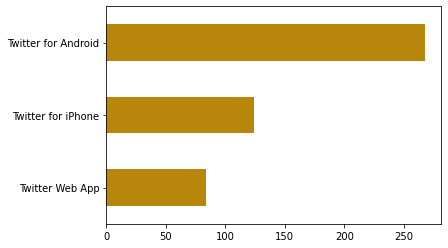

In [18]:
sources_sorted = sourceDF.sort_values('source')
ax = sources_sorted.source.plot(kind='barh',color='#B8860B')
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

**Análise temporal**

In [19]:
from datetime import datetime

In [20]:
data = tweets_df.copy()
print(data['Date'][0])

2020-10-02 13:34:25


In [21]:
# Converte a data para apenas dia/mês e ano
data['Date'] = pd.to_datetime(data['Date']).apply(lambda x: x.date())
print(data['Date'][0])

2020-10-02


In [22]:
#Quantidade de Tweets por dia
QtdeDiaria = data['Date'].value_counts() 
QtdeDiaria

2020-09-26    445
2020-09-27     41
2020-10-03     12
2020-10-01      1
2020-10-02      1
Name: Date, dtype: int64

**Análise de Polaridade**

In [23]:
# !pip install googletrans
# !pip install unidecode

In [24]:
from googletrans import Translator
from unidecode import unidecode

In [25]:
#Calcula a polaridade do texto traduzido

analysis = None
polarities = []

for tweet in tweets_df['Tweets']: 
    #Texto do Tweet
    textPT = unidecode(tweet)
    
    #Traduz para o Inglês
    textEN = Translator().translate(textPT)
    
    analysis = tb(textEN.text)    
    polarity = analysis.sentiment.polarity   
    polarities.append(polarity)

print('Vetor de polaridade:',polarities)

Vetor de polaridade: [0.0, 0.075, -0.2, 0.1, 0.5, -0.15, -0.15, -0.15, -0.5, -0.15, -0.55, 0.0, 0.0, 1.0, -0.15, -0.75, 0.5, 0.18333333333333335, 0.0, 0.375, -0.3, -0.3666666666666667, 0.5, 0.5, 0.5, 0.0, 0.5, 0.075, 0.5, 0.5, 0.5, 0.0, 0.0, 0.16666666666666666, 0.10606060606060606, 0.0, 0.0, 0.16666666666666666, 0.0, 0.3181818181818182, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, -0.75, 0.027083333333333327, 0.0, 0.16666666666666666, 0.05, 0.0, 0.0, 0.0, 0.4666666666666666, 0.0, 0.0, -0.05, -0.49375, 0.16666666666666666, 0.16666666666666666, 0.3571428571428571, 0.8, 0.0, 0.75, -0.18375000000000002, 0.0, 0.16666666666666666, 0.5, 0.5, 0.16666666666666666, 0.0, 0.5, 0.5, 0.5, 0.0, 0.0, 0.4, 0.16666666666666666, 0.5, 0.5, 0.425, -0.05, 0.5, 0.5, -0.12083333333333333, -0.13499999999999995, 0.0, 0.10000000000000002, 0.5, 0.5, -0.05714285714285716, 0.16666666666666666, 0.16666666666666666, 0.05, 0.16666666666666666, -0.12083333333333333, 0.275, 0.0, 0.11071428571428571, 0.13333333333333333, 0.192803

**Análise de sentimentos**

In [26]:
print('Para a(s) palavra(s):"%s"' % keyword)
print('A MÉDIA DE SENTIMENTO É: ' + str(np.mean(polarities)))

Para a(s) palavra(s):"home office OR #homeoffice"
A MÉDIA DE SENTIMENTO É: 0.1252870045319264


In [27]:
positive = 0
negative = 0
neutral = 0

for polarity in polarities:
    if polarity > 0:
        positive = positive+1
    elif polarity < 0:
        negative = negative+1
    else:
        neutral = neutral+1
        
print("Tweets Positivos: %s" % positive)
print("Tweets Negativos: %s" % negative)
print("Tweets Neutros: %s" % neutral)

# Calcula percentual
pos_pct=positive*100/len(polarities)
neg_pct=negative*100/len(polarities)
neu_pct=neutral*100/len(polarities)

Tweets Positivos: 303
Tweets Negativos: 67
Tweets Neutros: 130


In [28]:
# Define variáveis
sentiments = ['Positivos', 'Negativos','Neutros']
percents = [pos_pct, neg_pct, neu_pct]

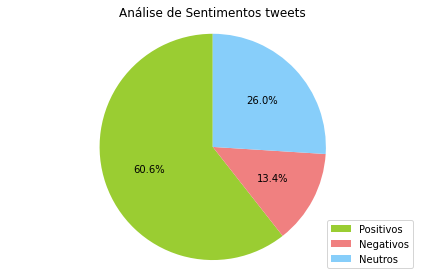

In [29]:
# plota o gráfico de análise

colors = ['yellowgreen', 'lightcoral', 'lightskyblue'] #Personalizar as cores

plt.pie(percents,colors=colors , autopct='%1.1f%%', startangle=90)
plt.legend(sentiments, loc="best")
plt.title("Análise de Sentimentos tweets")
plt.axis('equal')
plt.tight_layout()
plt.show()                

**Mapa dos tweets**

In [30]:
from geopy.geocoders import Nominatim
import folium
from folium import plugins

In [31]:
geolocator = Nominatim(user_agent="TwitterSentimentAnalysis")

# armazena a latitude e a longitude
latitude = []
longitude = []

for user_location in tweets_df['User Location']:
    try:
        location = geolocator.geocode(user_location) 
        latitude.append(location.latitude)
        longitude.append(location.longitude)
    except:
        continue

In [32]:
coordenadas = np.column_stack((latitude, longitude))

mapa = folium.Map(zoom_start=3)
mapa.add_child(plugins.HeatMap(coordenadas))
mapa.save('mapa_calor_tweets.html')
mapa

**Nuvem de Palavras**

In [33]:
import re
import string
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.simplefilter('ignore')

In [34]:
words = ' '.join(tweets_df['Tweets'])
words

'Adesão ao naturismo para home office no Rio 🔥: não confirmo nem nego. Bela notícia: home office no serviço público gerou economia de R$ 1 bilhão em 5 meses, no governo federal. Triste é pensar que gastaremos o dobro disso com políticos com o Fundo Eleitoral... mesmo com eles fazendo campanha de casa. https://t.co/LcewNrUksh mais alguém aí de home office sentindo falta do ar condicionado da firma?   Que calor dos 🔥🔥🔥 toda família tem e sem contar que só pq vc trabalha de home office vc tem que fazer toda tarefa de casa, por estar em casa e ninguem faz porra nenhuma mais https://t.co/80gvg4weOP D\'Alessandro de home office é melhor que todo meio campo do Inter. É só analisar o passe cirúrgico que ele deu pro Galhardo buscar o gol, e é uma coisa que vamos sentir falta quando ele se aposentar de fato. https://t.co/H7BXTYkfzV Home Office pode aumentar renda média brasileira, aponta estudo.  https://t.co/TmFtMVQfPK  via @GoogleNews Home Office pode aumentar renda média brasileira, aponta es

In [47]:
# Limpeza dos dados

words = words.lower() # minúsculas
words = re.sub(r'[?|$|.|:|!|,]',r'',words) #remove pontuação
words = re.sub('[0-9]+', '', words) #remove números
words = re.sub(r'@\S+', '', words) # remove mentions ou menções
words = re.sub(r'#\S+', '', words) # remove hashtags
words = re.sub(r"http\S+", "", words) # remove hyperlinks

words

'adesão ao naturismo para home office no rio 🔥 não confirmo nem nego bela notícia home office no serviço público gerou economia de r  bilhão em  meses no governo federal triste é pensar que gastaremos o dobro disso com políticos com o fundo eleitoral mesmo com eles fazendo campanha de casa  mais alguém aí de home office sentindo falta do ar condicionado da firma   que calor dos 🔥🔥🔥 toda família tem e sem contar que só pq vc trabalha de home office vc tem que fazer toda tarefa de casa por estar em casa e ninguem faz porra nenhuma mais  d\'alessandro de home office é melhor que todo meio campo do inter é só analisar o passe cirúrgico que ele deu pro galhardo buscar o gol e é uma coisa que vamos sentir falta quando ele se aposentar de fato  home office pode aumentar renda média brasileira aponta estudo    via  home office pode aumentar renda média brasileira aponta estudo   home office pode aumentar renda média brasileira aponta estudo   depois de meses em home office o espírito guerreiro

In [48]:
words_clean = " ".join([word for word in words.split()
                            if word != 'RT'
                            ])

In [55]:
stopwords = ["da", "do", "na", "no", "meu", "em", "das", 
             "de", "ao", "os", "as", "se", "que", "não", 
             "pra", "para", "por", "com", "me", "há"]

In [56]:
wordcloud = WordCloud(stopwords=stopwords, max_words=100,
                      background_color='black', width=1600,                            
                      height=800, collocations=False).generate(words_clean)

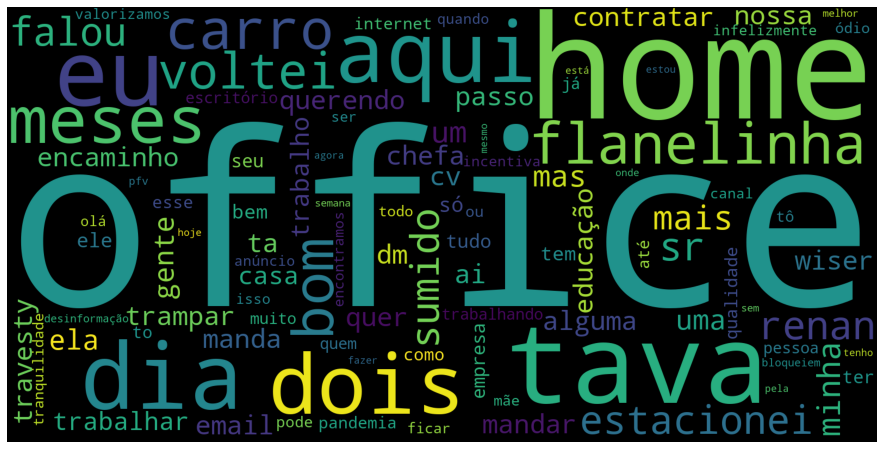

In [57]:
# plota a word cloud de Sertanejo
fig, ax = plt.subplots(figsize=(16,8))            
ax.imshow(wordcloud, interpolation='bilinear')       
ax.set_axis_off()
plt.savefig('tweets_wordcloud.png', dpi=150)
plt.imshow(wordcloud)



---



**Referências:**    

* http://docs.tweepy.org/en/v3.5.0/api.html    
* https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/intro-to-tweet-json
* https://textblob.readthedocs.io/en/dev/#    
* https://pypi.org/project/geopy/   
* https://python-visualization.github.io/folium/  
* https://pypi.org/project/wordcloud/



In [39]:
# Author: Priscilla Bomfim (@priscillapreks)
# Data: 03.10.2020